In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # 모델 저장용

# Scikit-learn 라이브러리
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neural_network import MLPClassifier # 딥러닝(신경망) 모델
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# 그래프 스타일 설정
plt.style.use('seaborn-v0_8')

print("✅ 라이브러리 로드 완료")

✅ 라이브러리 로드 완료


In [12]:
# 파일 로드 (파일명이 다르다면 수정해주세요)
file_path = 'data.csv'

try:
    df = pd.read_csv(file_path)
    print(f"✅ 데이터 로드 성공: {len(df)}개 샘플")
    display(df.head(3))
except FileNotFoundError:
    print("❌ 파일을 찾을 수 없습니다. 좌측 파일 탭에 CSV 파일을 업로드해주세요.")

✅ 데이터 로드 성공: 409개 샘플


,headline,original_category,category
0,Drug Arrests and Gun Seizures Fell as Homeland...,Politics,Politics
1,Trump Administration Is Taking Billions in Sta...,Politics,Politics
2,"Despite an Election Loss, Deja Foxx, Continues...",Politics,Politics


In [16]:
# [Cell 3] 데이터 인코딩 및 분할 (수정됨)
from sklearn.preprocessing import LabelEncoder

# Feature(X)와 Target(y) 준비
X = df['headline']
y_text = df['category'] # 원래 텍스트 라벨

# -----------------------------------------------------------
# 🛠️ [Fix] 라벨 인코딩 (Text -> Number)
# 'Economy', 'Politics' 등을 0, 1, 2... 숫자로 변환합니다.
# -----------------------------------------------------------
le = LabelEncoder()
y = le.fit_transform(y_text)

print("✅ 라벨 인코딩 완료:")
for index, label in enumerate(le.classes_):
    print(f"   {index} -> {label}")

# -----------------------------------------------------------
# 데이터 분할 (Stratified Split)
# -----------------------------------------------------------
# 1. Train+Val (80%) vs Test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Train (64%) vs Validation (16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"\n📌 데이터 분할 결과:")
print(f" - Training Set:   {len(X_train)}개")
print(f" - Validation Set: {len(X_val)}개")
print(f" - Test Set:       {len(X_test)}개")

✅ 라벨 인코딩 완료:
   0 -> CS_Insight
   1 -> Economy
   2 -> Politics
   3 -> Society
   4 -> Technology

📌 데이터 분할 결과:
 - Training Set:   245개
 - Validation Set: 82개
 - Test Set:       82개


In [14]:
# MLP 파이프라인 구축
pipeline = Pipeline([
    # 1. 입력층 (Input Layer): 텍스트 -> 숫자 벡터 (TF-IDF)
    ('tfidf', TfidfVectorizer(stop_words='english', max_features=3000)),

    # 2. 은닉층 & 출력층 (Hidden & Output Layers): 다층 퍼셉트론
    ('clf', MLPClassifier(
        hidden_layer_sizes=(128, 64), # 은닉층 2개 (노드 128개, 64개)
        activation='relu',            # 활성화 함수
        solver='adam',                # 최적화 알고리즘
        batch_size=32,                # 미니 배치 크기
        learning_rate_init=0.001,     # 학습률
        max_iter=200,                 # 최대 Epoch 수
        early_stopping=True,          # 과적합 방지 (성능 안 오르면 조기 종료)
        validation_fraction=0.1,      # 내부 검증 비율
        random_state=42,
        verbose=True                  # Epoch별 로그 출력 (과제 필수 요건!)
    ))
])

print("✅ 모델 아키텍처 설계 완료: TF-IDF + MLP(2 Hidden Layers)")

✅ 모델 아키텍처 설계 완료: TF-IDF + MLP(2 Hidden Layers)


🔥 신경망 학습 시작 (Epoch별 Loss 로그 확인)...
Iteration 1, loss = 1.67900146
Validation score: 0.160000
Iteration 2, loss = 1.61548024
Validation score: 0.160000
Iteration 3, loss = 1.56580616
Validation score: 0.280000
Iteration 4, loss = 1.50924301
Validation score: 0.360000
Iteration 5, loss = 1.44193259
Validation score: 0.400000
Iteration 6, loss = 1.35817862
Validation score: 0.400000
Iteration 7, loss = 1.25270575
Validation score: 0.400000
Iteration 8, loss = 1.12455919
Validation score: 0.400000
Iteration 9, loss = 0.97733275
Validation score: 0.400000
Iteration 10, loss = 0.81113635
Validation score: 0.440000
Iteration 11, loss = 0.64130480
Validation score: 0.360000
Iteration 12, loss = 0.47955451
Validation score: 0.360000
Iteration 13, loss = 0.33844129
Validation score: 0.440000
Iteration 14, loss = 0.23147005
Validation score: 0.440000
Iteration 15, loss = 0.15192436
Validation score: 0.440000
Iteration 16, loss = 0.09822170
Validation score: 0.480000
Iteration 17, loss = 0.0657209

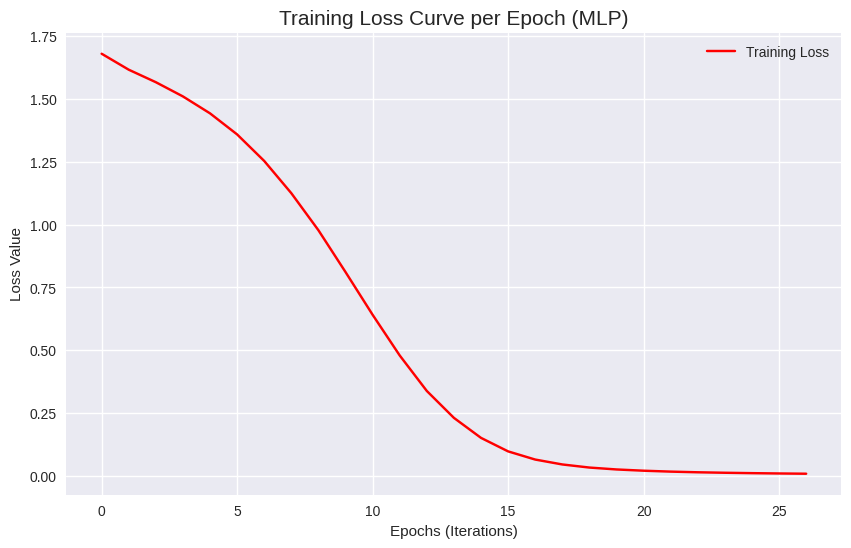

📈 학습이 진행될수록 Loss(오차)가 감소하는 것을 시각적으로 확인했습니다.


In [17]:
print("🔥 신경망 학습 시작 (Epoch별 Loss 로그 확인)...")

# 1. 학습 (Training)
pipeline.fit(X_train, y_train)

# 2. Validation 성능 확인
val_pred = pipeline.predict(X_val)
print("\n[Validation Set 성능 Report]")
print(classification_report(y_val, val_pred))

# 3. [핵심] Epoch별 Loss Curve 시각화 (평가 기준 충족)
# 파이프라인 내부의 'clf' 모델 객체를 꺼내옵니다.
mlp_model = pipeline.named_steps['clf']

plt.figure(figsize=(10, 6))
plt.plot(mlp_model.loss_curve_, label='Training Loss', color='red')
plt.title('Training Loss Curve per Epoch (MLP)', fontsize=15)
plt.xlabel('Epochs (Iterations)')
plt.ylabel('Loss Value')
plt.legend()
plt.grid(True)

# 그래프 저장 (보고서용)
plt.savefig('loss_curve.png')
plt.show()

print("📈 학습이 진행될수록 Loss(오차)가 감소하는 것을 시각적으로 확인했습니다.")

In [20]:
# 1. 모델과 인코더를 묶어서 저장 (Dictionary 형태)
# 이렇게 해야 evaluation에서 model['model'], model['encoder']로 꺼낼 수 있습니다.
saved_object = {
    'model': pipeline,  # 학습 완료된 모델
    'encoder': le       # 'Politics' <-> 0 변환기
}

model_filename = 'news_classifier_model.pkl'
joblib.dump(saved_object, model_filename)
print(f"✅ 모델 및 인코더 저장 완료: {model_filename}")

# 2. Test 데이터셋도 평가용으로 같이 저장 (숫자 라벨을 다시 문자로 복구해서 저장)
# evaluation.ipynb에서 이 파일을 불러와서 평가합니다.
test_df = pd.DataFrame({
    'headline': X_test,
    'category': le.inverse_transform(y_test) # 0, 1 -> 'Economy', 'Politics'
})
test_df.to_csv('test_dataset.csv', index=False)
print("✅ Test 데이터셋 저장 완료: test_dataset.csv")

# 3. 파일 다운로드 (코랩)
from google.colab import files
try:
    files.download(model_filename)
    files.download('test_dataset.csv')
    files.download('loss_curve.png') # 아까 그린 그래프도 있다면 다운로드
except Exception as e:
    print(f"다운로드 중 오류 발생 (무시 가능): {e}")

✅ 모델 및 인코더 저장 완료: news_classifier_model.pkl
✅ Test 데이터셋 저장 완료: test_dataset.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>